### Your name:

<pre> Nitin Prakash Panicker</pre>

### Collaborators:

<pre> </pre>


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Open the housing data


In [3]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Build a full pipeline for data analysis following the example of the module notebook.
 Hint: the main change is the algorithm used (Lasso regression)

If you want to learn more about the Lasso regression, see resources below:
- http://scikit-learn.org/stable/modules/linear_model.html#lasso
- https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

#### Considerations for building a pipeline:

- Split data into training and testing sets (1 mark)
- Convert all categorical data to one-hot vectors below inside a pipeline (2 marks)
- Normalize all non-categorical data inside the same pipeline (2 marks)
- Perform Lasso-based regression (1 mark)
- Perform a grid search using a variety of values for $\alpha$ between 0 and 1 where *housing_labels* is the output and all other features are the input (2 marks)

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


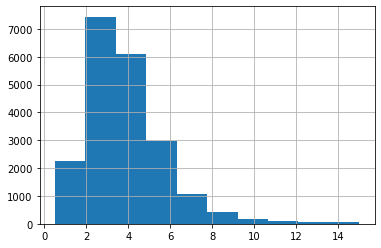

In [5]:
# As per experts (business), median income is a very important attribute to predict housing prices. 
# Since median income is a continuous numerical attribute, we need to first create an income category attribute. 

#  Let’s look at the median income histogram more closely
housing["median_income"].hist();

In [6]:
# The following code creates an income category 
# attribute by dividing the median income by 1.5 (to limit the number of income cate‐gories), 
# and rounding up using ceil (to have discrete categories), and then merging
# all the categories greater than 5 into category 5

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [7]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

### Train-Test split based on stratified sampling technique

In [8]:
# Now we are ready to do stratified sampling based on the income category. 
# For this we can use Scikit-Learn’s StratifiedShuffleSplit class

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [9]:
# income category proportions in the full housing dataset

housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [10]:
# Now you should remove the income_cat attribute so the data is back to its original state:

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [11]:
housing = strat_train_set.copy()

### Attribute combinations:

In [12]:
# the total number of rooms in a district is not very useful if you don’t know how many
# households there are. What you really want is the number of rooms per household.
# Similarly, the total number of bedrooms by itself is not very useful: you probably
# want to compare it to the number of rooms. And the population per household also
# seems like an interesting attribute combination to look at. Let’s create these new
# attributes:

In [13]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [14]:
# And now let’s look at the correlation matrix again:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### Prepare data for machine learning algorithms:

In [15]:
# let’s revert to a clean training set (by copying strat_train_set once again),
# and let’s separate the predictors and the labels since we don’t necessarily want to apply
# the same transformations to the predictors and the target values

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [16]:
# Fill missing values for total_bedrooms using sci-kit learn Imputer
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

In [17]:
# Since the median can only be computed on numerical attributes, we need to create a
# copy of the data without the text attribute ocean_proximity:

housing_num = housing.drop("ocean_proximity", axis=1)

In [18]:
# Now you can fit the imputer instance to the training data using the fit() method:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [19]:
# Transfer the training set:
# Now we can use this “trained” imputer to transform the training set by replacing missing values by the learned medians:

X = imputer.transform(housing_num)

In [20]:
# The result is a plain Numpy array containing the transformed features. If you want to
# put it back into a Pandas DataFrame, it’s simple:

housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [21]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### Handling Text and Categorical Attributes:

In [22]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [23]:
from sklearn.preprocessing import OrdinalEncoder

In [24]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [25]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [26]:
from sklearn.preprocessing import OneHotEncoder

In [27]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### Custom Transformers to  add extra attributes:

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [29]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### Transformation Pipelines

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [31]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [32]:
from sklearn.compose import ColumnTransformer

In [33]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

#housing_prepared = full_pipeline.fit_transform(housing)

In [34]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [35]:
housing_prepared.shape

(16512, 16)

In [36]:
from sklearn.linear_model import Lasso

# Write your code here:
lasso = Lasso(alpha=0.1)
lasso.fit(housing_prepared, housing_labels)
#lasso_error = calculate_rmse(lasso, 'Lasso Reg')

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6387975536398.07, tolerance: 22103585513.76512
  positive)


Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [37]:
print(lasso.coef_)

[-55649.69623971 -56715.68160335  13732.97013106  -1930.40246579
   7328.92163613 -45707.69311818  45453.38957137  74714.08082073
   6604.70432957   1042.78205511   9250.09312996  14558.19020894
 -22644.85155224 142106.58083121  10093.85890506  17931.50098746]


In [38]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lasso.predict(some_data_prepared))

Predictions: [210644.9970783  317768.2531878  210955.57732393  59219.78605864
 189746.677462  ]


In [39]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [40]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [41]:
from sklearn.metrics import mean_squared_error

housing_predictions = lasso.predict(housing_prepared)
lasso_mse = mean_squared_error(housing_labels, housing_predictions)
lasso_rmse = np.sqrt(lasso_mse)
lasso_rmse

68628.19880703553

In [42]:
from sklearn.metrics import mean_absolute_error

lasso_mae = mean_absolute_error(housing_labels, housing_predictions)
lasso_mae

49439.9232897164

#### Grid Search

In [43]:
from sklearn.linear_model import LassoCV

In [44]:
reg = LassoCV(cv=5, random_state=0).fit(housing_prepared, housing_labels)

In [47]:
reg.score(housing_prepared,housing_labels)

0.6474231155660904

In [51]:
reg.predict(housing_prepared)

array([207449.99701277, 314578.37873388, 209065.64635044, ...,
       100176.40361568, 215597.92256334, 275672.95313929])


Why is it necessary to normalize all continuous variables before performing Lasso? (OPTIONAL)

<pre> WRITE RESPONSE HERE </pre>

### Conclusions (2 marks)
What values of $\alpha$ make Lasso perform best? Does it perform as well on the housing data as the linear regressor from the lectures? Why do you think this is?

<pre> WRITE RESPONSE HERE </pre>

### Read appendix B

- Reflect on your last data project, read appendix B. Then, write down a few of the checklist items that your last data project could have used. If you have not yet done a data project, then write down a few of the items that you found most interesting.


In [ ]:
#YOUR ANSWER HERE